In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    """
    Downloads daily data from yfinance.
    Adjust the ticker, start, and end date as desired.
    """
    df = yf.download(ticker, start=start, end=end, progress=False)
    # Rename columns to standardize
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df

In [2]:
def sma_crossover_signals(df, short_window=20, long_window=50):
    """
    Compute signals for SMA crossover strategy.
    Returns a DataFrame with 'signal' column (1=long, -1=short, 0=flat).
    """
    df['SMA_short'] = df['close'].rolling(short_window).mean()
    df['SMA_long']  = df['close'].rolling(long_window).mean()
    
    df['signal'] = 0
    df.loc[df['SMA_short'] > df['SMA_long'], 'signal'] = 1
    df.loc[df['SMA_short'] < df['SMA_long'], 'signal'] = -1
    return df

In [3]:
def backtest_strategy(df, initial_capital=10000):
    """
    Simple backtest:
    - Goes long when signal=1, short when signal=-1.
    - Closes position when signal changes from 1 to -1 or vice versa.
    - This is naive (no transaction costs/slippage).
    """
    df['returns'] = df['close'].pct_change().fillna(0)
    # Strategy returns: shift signal by 1 day (execute on next day’s open, approx)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    
    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Calculate metrics
    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    # Daily Sharpe ratio approximation with ~252 trading days in a year
    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)  
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

In [4]:
def plot_results(df):
    """
    Plots price with signals and the equity curve.
    """
    fig, ax = plt.subplots()
    ax.plot(df.index, df['close'], label='Price')
    ax.plot(df.index, df['SMA_short'], label='SMA_short')
    ax.plot(df.index, df['SMA_long'], label='SMA_long')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', label='Buy Signal')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', label='Sell Signal')
    ax.set_title("SMA Crossover Strategy - Price & Signals")
    ax.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(df.index, df['cumulative_market'], label='Market Returns')
    ax.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    ax.set_title("SMA Crossover Strategy - Equity Curve")
    ax.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 6056.78
Total Return: -39.43%
Max Drawdown: 60.66%
Sharpe Ratio: -0.03


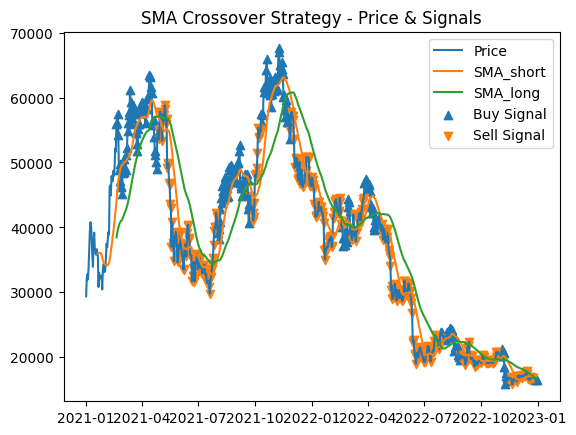

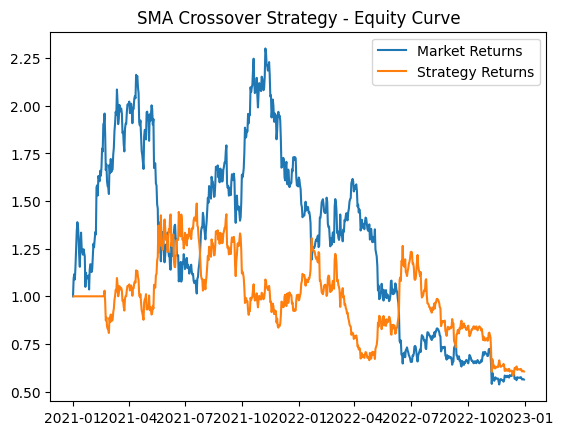

In [5]:
# 1. Download data
data = download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01")

# 2. Compute signals
data = sma_crossover_signals(data, short_window=20, long_window=50)

# 3. Backtest
data, metrics = backtest_strategy(data, initial_capital=10000)

# 4. Print metrics
print("Performance Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v}")

# 5. Plot
plot_results(data)